In [213]:
import pandas as pd
import requests
import json
import csv
import re
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
import matplotlib.dates as mdates
from matplotlib.ticker import MultipleLocator

In [431]:
run_df = pd.read_csv('TWO_CENTURIES_OF_UM_RACES.csv')
run_df.columns
# filtered_df = run_df[run_df['Year of event'].isin([2018, 2017])]
#pd.DataFrame(run_df['Event distance/length'].unique()).to_csv("dirty_distances.csv", index=False)


/var/folders/9l/z_l2kfhx3zz2bllv2tnpjht00000gn/T/ipykernel_52162/2937963534.py:1: DtypeWarning: Columns (11) have mixed types. Specify dtype option on import or set low_memory=False.
  run_df = pd.read_csv('TWO_CENTURIES_OF_UM_RACES.csv')


2159

In [116]:
#CLEANING DATA BASED ON RACE DISTANCE

#Removing Races that are not distance based
# Ensure the column is treated as a string and remove rows that contain 'h' for hours
run_df['distance'] = run_df['Event distance/length'].astype(str)

#Taking only the rows that do not contain the letter h. ~ inverts boolean T becomes F
run_df = run_df[~run_df['distance'].str.contains('h')]

#Alot of my variables had unwanted added info. Removing all info after 'mi' or 'km'
run_df['distance'] = run_df['distance'].str.split('/').str[0]


#DF with just races in miles
mi_run_df = run_df[run_df['distance'].str.contains('mi')]

#Remove alphabetical characters and convert the column to numeric
mi_run_df['distance'] = mi_run_df['distance'].str.replace(r'[A-Za-z]', '', regex=True)
mi_run_df['distance'] = pd.to_numeric(mi_run_df['distance'], errors='coerce')

#Convert to KM
mi_run_df['distance'] = mi_run_df['distance']*1.60934



#DF with just races in kilometers
km_run_df = run_df[run_df['distance'].str.contains('km')]


#Remove alphabetical characters and convert the column to numeric
km_run_df['distance'] = km_run_df['distance'].str.replace(r'[A-Za-z]', '', regex=True)
km_run_df['distance'] = pd.to_numeric(km_run_df['distance'], errors='coerce')


#Return to One DataFrame
df = pd.concat([mi_run_df, km_run_df], ignore_index=True)





/var/folders/9l/z_l2kfhx3zz2bllv2tnpjht00000gn/T/ipykernel_52162/3265419739.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_run_df['distance'] = mi_run_df['distance'].str.replace(r'[A-Za-z]', '', regex=True)
/var/folders/9l/z_l2kfhx3zz2bllv2tnpjht00000gn/T/ipykernel_52162/3265419739.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mi_run_df['distance'] = pd.to_numeric(mi_run_df['distance'], errors='coerce')
/var/folders/9l/z_l2kfhx3zz2bllv2tnpjht00000gn/T/ipykernel_52162/3265419739.py:22: Settin

In [252]:
df['time_delta'] = pd.to_timedelta(df['Athlete performance'])

# Convert Timedelta to numeric hours
df['hours'] = df['time_delta'].dt.total_seconds() / 3600

df['hours'].mean()

np.float64(11.907381753617447)

In [409]:
#More Distance Based Cleaning to improve usability 
#rounding to the nearest 10
df['distance_rounded'] = (df['distance'] / 5).round() * 5

#Eliminating really long stage races
df = df[df['distance_rounded']< 500]

#Bucketing Distances
bins = [0, 50, 70, 90, 120, 150, 180, float('inf')]
labels = ['<50', '50-70', '71-90', '91-120', '121-150', '151-180', '>180']
df['distance_range'] = pd.cut(df['distance_rounded'], bins=bins, labels=labels, right=True)

#Athlete Age on Race Day

bins2 = [0, 19, 29, 39, 49, 59, 69, 79, float('inf')]
labels2 = ['<20', '20-29', '30-39', '40-49', '50-59', '60-69', '70-79', '>80']
df['age_at_race'] = df['Year of event'] - df['Athlete year of birth']
df['age_cat'] = pd.cut(df['age_at_race'], bins=bins2, labels=labels2, right=True)

#100 Milers
df_100 = df[(df['distance_rounded']< 170) & (df['distance_rounded'] >160)]

df_100.to_csv(".csv", index=False)




In [407]:
# Going to find all locations for 100s
races_100 = df_100['Event name'].unique()

np.savetxt('output.csv', races_100, delimiter=',', fmt='%s')

In [408]:
#Bringing back in 100s locations
locations = pd.read_csv('locations2.csv')
locations = locations.drop(locations.columns[0], axis=1)
locations = locations.drop(locations.columns[2], axis=1)

#fixing labeling bugs
locations['Race'] = locations['Race'].replace('Mace', 'Mace´s Hideout 100 Mile Race (USA)')
locations['Race'] = locations['Race'].replace('Sands', 'Sandsjöbacka Trail - Ultratrippeln  (SWE)')

#merging in locations
merged_100 = pd.merge(df_100, locations, left_on='Event name', right_on='Race', how='inner')

merged_100.to_csv("merged_100.csv", index=False)


#Fixing date to proper format
merged_100['date_extracted'] = merged_100['Event dates'].str.split('-').str[1]
merged_100['race_date'] = pd.to_datetime(merged_100['date_extracted'], format='%d.%m.%Y')
merged_100['race_date'] = merged_100['race_date'].dt.strftime('%Y-%m-%d')
merged_100= merged_100.dropna(subset=['race_date'])


#unique races
unique_races= merged_100[['Location', 'race_date']].drop_duplicates().reset_index(drop=True)

place = unique_races['Location'].tolist()
dates = unique_races['race_date'].tolist()

In [193]:
#DONT RUN AGAIN
# API configuration
api_endpoint = 'http://api.weatherstack.com/historical'
api_key = '2d41f47d58a932107f900dedc410321a'
weather_locations = place
historical_dates = dates
csv_output = '100s_historical_weather.csv'

# Ensure the lists have the same length
if len(weather_locations) != len(historical_dates):
    raise ValueError("The number of locations must match the number of dates.")

# Open CSV file for writing
with open(csv_output, mode='w', newline='') as file:
    # Define CSV columns
    fieldnames = ['location', 'date', 'mintemp', 'maxtemp', 'avgtemp', 'totalsnow', 'sunhour']
    writer = csv.DictWriter(file, fieldnames=fieldnames)
    writer.writeheader()

    # Iterate over paired locations and dates
    for location, date in zip(weather_locations, historical_dates):
        params = {
            'access_key': api_key,
            'query': location,
            'historical_date': date,
            'hourly': '1'  # Include hourly data if needed
        }
        response = requests.get(api_endpoint, params=params)

        # Check if the API request was successful
        if response.status_code == 200:
            data = response.json()

            # Check if historical data is available
            if 'historical' in data and date in data['historical']:
                historical_data = data['historical'][date]
                writer.writerow({
                    'location': location,
                    'date': date,
                    'mintemp': historical_data.get('mintemp'),
                    'maxtemp': historical_data.get('maxtemp'),
                    'avgtemp': historical_data.get('avgtemp'),
                    'totalsnow': historical_data.get('totalsnow'),
                    'sunhour': historical_data.get('sunhour')
                })
            else:
                print(f"No historical weather data available for {location} on {date}.")
        else:
            print(f"Failed to retrieve data for {location} on {date}. HTTP Status code: {response.status_code}")






No historical weather data available for Chamonix, France on 2007-08-26.


In [360]:
#Incorportate API Data into other data
weather_100s = pd.read_csv('100s_historical_weather.csv')
weather_100s['Location']= weather_100s['location']
weather_100s['race_date']= weather_100s['date']

merged_100_weather = pd.merge(merged_100, weather_100s, on=['Location', 'race_date'], how='inner')
merged_100_weather.to_csv("merged_100_weather.csv", index=False)

In [438]:
#### VISUALIZATIONS###


135.0

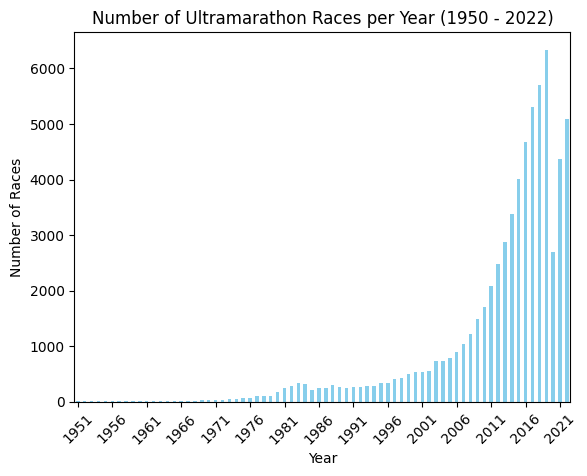

In [362]:
#1
#Histogram of Races Per Year
all_unique_races= df.drop_duplicates(subset=['Event name', 'Event dates'])
all_unique_races = all_unique_races[all_unique_races['Year of event'] > 1950]

yearly_counts = all_unique_races['Year of event'].value_counts().sort_index()


# Plot the histogram
fig, ax = plt.subplots()
yearly_counts.plot(kind='bar', ax=ax, color='skyblue')

# Set x-axis major ticks to every 5 years
ax.xaxis.set_major_locator(MultipleLocator(5))

# Format x-axis labels to show the year
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of Races')
ax.set_title('Number of Ultramarathon Races per Year (1950 - 2022)')

# Show the plot
plt.show()




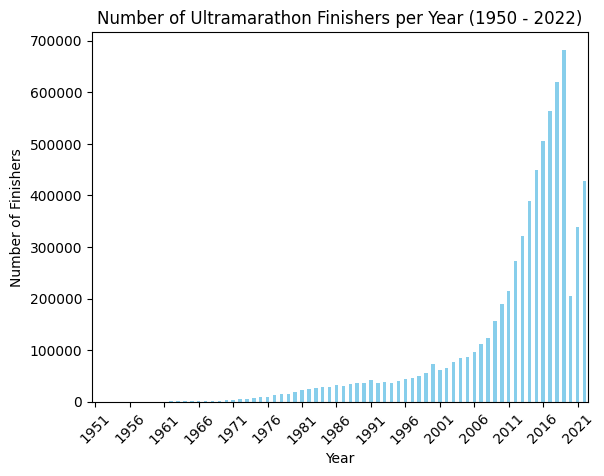

In [363]:
#2
#Histogram of Ultra Marathon Finishes Per Year
relevant_years = df[df['Year of event'] > 1950]

yearly_finishers= relevant_years['Year of event'].value_counts().sort_index()


# Plot the histogram
fig, ax = plt.subplots()
yearly_finishers.plot(kind='bar', ax=ax, color='skyblue')

# Set x-axis major ticks to every 5 years
ax.xaxis.set_major_locator(MultipleLocator(5))

# Format x-axis labels to show the year
# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Set labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Number of Finishers')
ax.set_title('Number of Ultramarathon Finishers per Year (1950 - 2022)')

# Show the plot
plt.show()

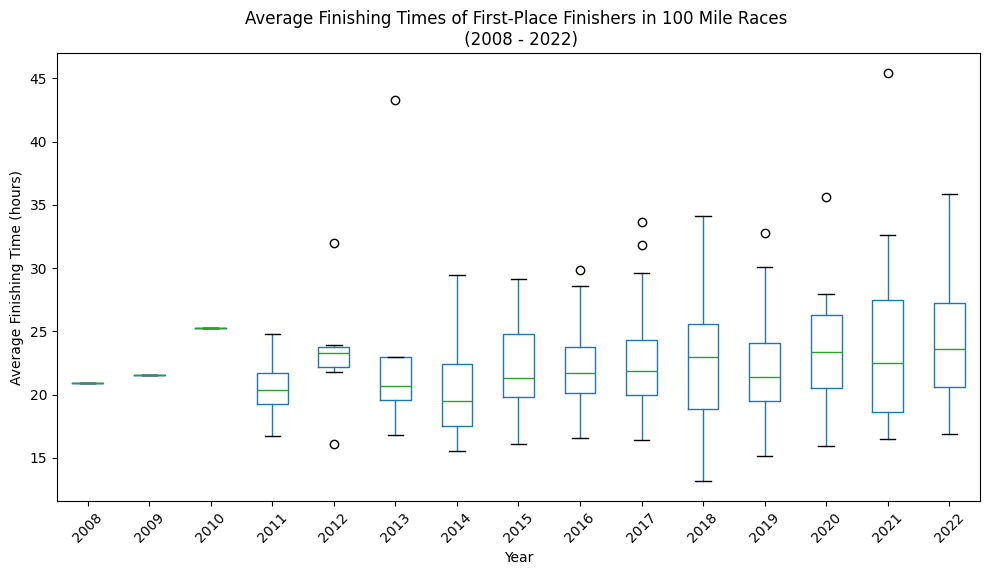

In [364]:
# 3
#  100 Mile average fastest time by year

#Finding First place finishers for each 100 mile race
idx = merged_100_weather.groupby(['Location', 'race_date'])['hours'].idxmin()
# Use the indices to select the corresponding rows from the original DataFrame
first_place_100s = merged_100_weather.loc[idx].reset_index(drop=True)

average_times_per_year_100s = first_place_100s.groupby('Year of event')['hours'].mean()

# Plot the average finishing times per year
fig, ax = plt.subplots(figsize=(10, 6))
first_place_100s.boxplot(column='hours', by='Year of event', ax=ax, grid=False)
ax.set_xlabel('Year')
ax.set_ylabel('Average Finishing Time (hours)')
ax.set_title('Average Finishing Times of First-Place Finishers in 100 Mile Races \n (2008 - 2022)')
plt.suptitle('')  # Suppress the default title to avoid redundancy
ax.xaxis.set_major_locator(MultipleLocator(1))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

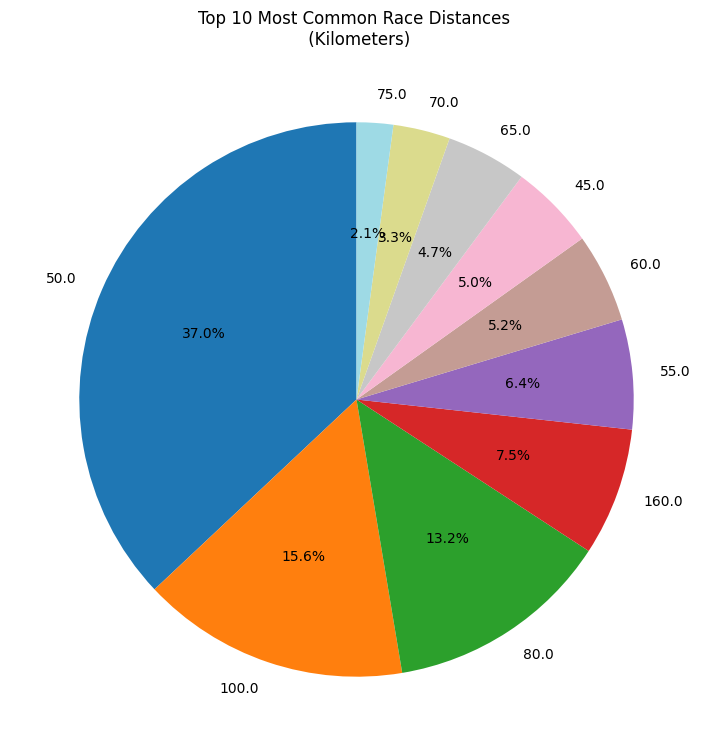

In [365]:
#4
# Common distances
common_distances_10 = all_unique_races['distance_rounded'].value_counts().head(10)

plt.figure(figsize=(9, 9))
common_distances_10.plot.pie(autopct='%1.1f%%', startangle=90, cmap='tab20')
plt.ylabel('')  # Hide the y-label
plt.title('Top 10 Most Common Race Distances \n (Kilometers)')
plt.show()

<Figure size 1200x600 with 0 Axes>

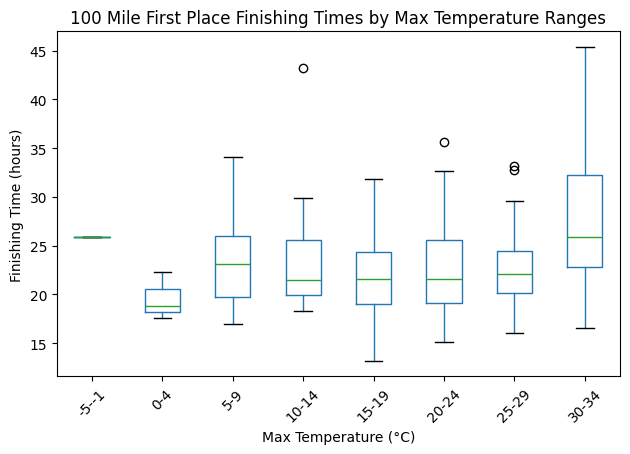

In [366]:
#5
#100 Mile Finishing Times by Max Temp

idx2 = merged_100_weather.groupby(['Location', 'race_date'])['hours'].idxmin()
# Use the indices to select the corresponding rows from the original DataFrame
first_place_100s = merged_100_weather.loc[idx2].reset_index(drop=True)

# Define temperature bins
bin_edges = range(-5, 40, 5)
bin_labels = [f'{i}-{i+4}' for i in bin_edges[:-1]]

# Bin the 'max_temperature' data
first_place_100s['temp_bin'] = pd.cut(first_place_100s['maxtemp'], bins=bin_edges, labels=bin_labels, right=False)

# Plot the results
plt.figure(figsize=(12, 6))
first_place_100s.boxplot(column='hours', by='temp_bin', grid=False)
plt.xlabel('Max Temperature (°C)')
plt.ylabel('Finishing Time (hours)')
plt.title('100 Mile First Place Finishing Times by Max Temperature Ranges')
plt.suptitle('')  # Suppress the default title to avoid redundancy
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


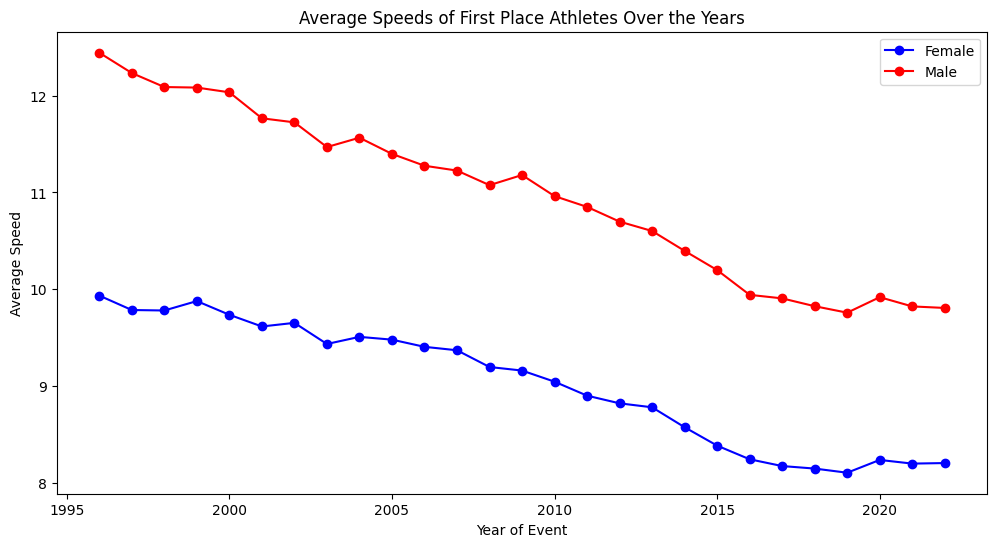

In [389]:
#6 
#Male vs Female 1st place finishers 

idx3 = df.groupby(['Event name', 'Event dates', 'Athlete gender'])['hours'].idxmin()
# Use the indices to select the corresponding rows from the original DataFrame
first_place_each_gender = df.loc[idx3].reset_index(drop=True)

# ensuring athletes have a average speed
first_place_each_gender['Athlete average speed'] = pd.to_numeric(first_place_each_gender['Athlete average speed'], errors='coerce')
first_place_each_gender = first_place_each_gender.dropna(subset=['Athlete average speed'])
first_place_each_gender = first_place_each_gender[first_place_each_gender['Athlete average speed'] <= 20]

#Only taking races with male and female finishers
# Group by 'race_event' and count unique 'gender' entries
gender_counts = first_place_each_gender.groupby('Event name')['Athlete gender'].nunique()

# Identify races with both male and female finishers
races_with_both_genders = gender_counts[gender_counts == 2].index
first_place_each_gender = first_place_each_gender[first_place_each_gender['Event name'].isin(races_with_both_genders)]







first_place_each_gender_average_yearly_speed  = first_place_each_gender.groupby(['Year of event', 'Athlete gender'])['Athlete average speed'].mean().unstack()
first_place_each_gender_average_yearly_speed = first_place_each_gender_average_yearly_speed.dropna(subset=['F'])

# Plot the average speeds over the years
plt.figure(figsize=(12, 6))
plt.plot(first_place_each_gender_average_yearly_speed.index, first_place_each_gender_average_yearly_speed['F'], label='Female', color='blue', marker='o')
plt.plot(first_place_each_gender_average_yearly_speed.index, first_place_each_gender_average_yearly_speed['M'], label='Male', color='red', marker='o')

# Adding titles and labels
plt.title('Average Speeds of First Place Athletes Over the Years')
plt.xlabel('Year of Event')
plt.ylabel('Average Speed')
plt.legend()

# Display the plot
plt.show()


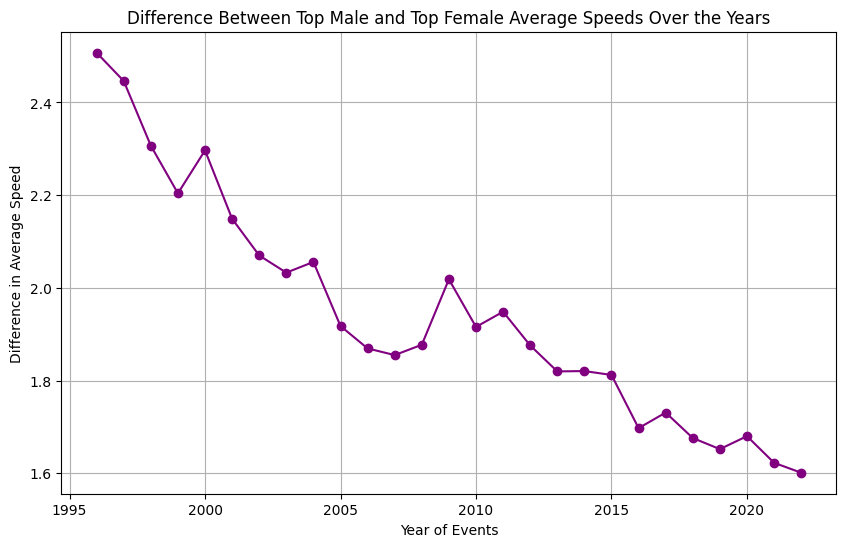

In [390]:
#7
#Average difference in Speed between Male and Female Top finishers
first_place_each_gender_average_yearly_speed['difference'] = first_place_each_gender_average_yearly_speed['M'] - first_place_each_gender_average_yearly_speed['F']


plt.figure(figsize=(10, 6))
plt.plot(first_place_each_gender_average_yearly_speed.index, first_place_each_gender_average_yearly_speed['difference'], marker='o', linestyle='-', color='purple')
plt.title('Difference Between Top Male and Top Female Average Speeds Over the Years')
plt.xlabel('Year of Events')
plt.ylabel('Difference in Average Speed')
plt.grid(True)
plt.show()


/var/folders/9l/z_l2kfhx3zz2bllv2tnpjht00000gn/T/ipykernel_52162/1435747050.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped123 = first_place_each_gender.groupby(['Athlete gender', 'distance_range'])['Athlete average speed'].mean().unstack()


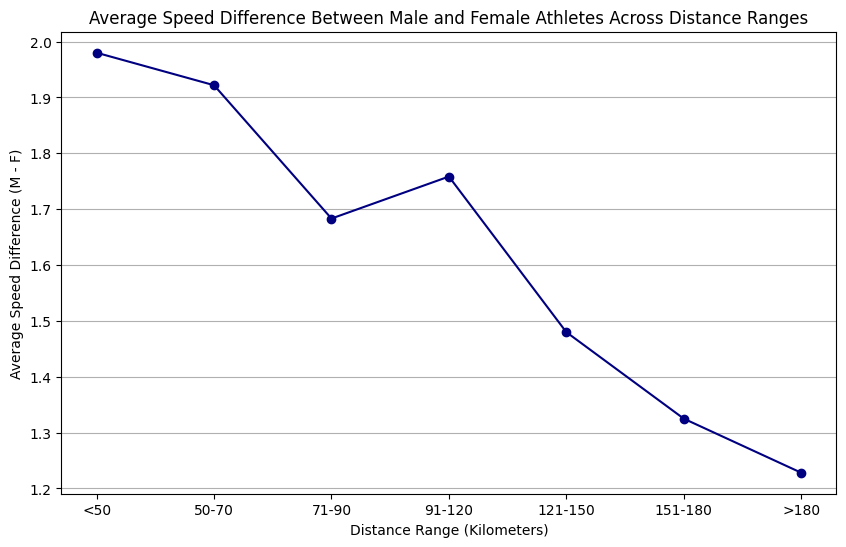

In [399]:
#8
#Male Female Speed Difference by Distance

grouped123 = first_place_each_gender.groupby(['Athlete gender', 'distance_range'])['Athlete average speed'].mean().unstack()
#grouped123 = grouped123.dropna(subset=['F'])


grouped123.loc['Difference'] = grouped123.loc['M'] - grouped123.loc['F']

plt.figure(figsize=(10, 6))
plt.plot(grouped123.columns, grouped123.loc['Difference'], marker='o', color='navy')
plt.title('Average Speed Difference Between Male and Female Athletes Across Distance Ranges')
plt.xlabel('Distance Range (Kilometers)')
plt.ylabel('Average Speed Difference (M - F)')
plt.grid(axis='y')
plt.show()


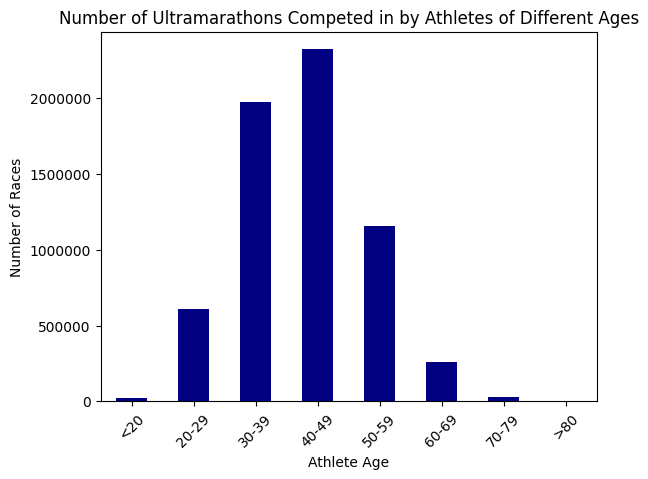

In [419]:
#9
#Athlete Ages 
athlete_ages= df['age_cat'].value_counts().sort_index()
athlete_ages

fig, ax = plt.subplots()
athlete_ages.plot(kind='bar', ax=ax, color='navy')
plt.xticks(rotation=45)
ax.set_xlabel('Athlete Age')
ax.set_ylabel('Number of Races')
ax.set_title('Number of Ultramarathons Competed in by Athletes of Different Ages')
ax.ticklabel_format(style='plain', axis='y')

plt.show()



/var/folders/9l/z_l2kfhx3zz2bllv2tnpjht00000gn/T/ipykernel_52162/706699212.py:9: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  average_speeds = ages_speed.groupby(['age_cat', 'distance_range'])['Athlete average speed'].mean().unstack()


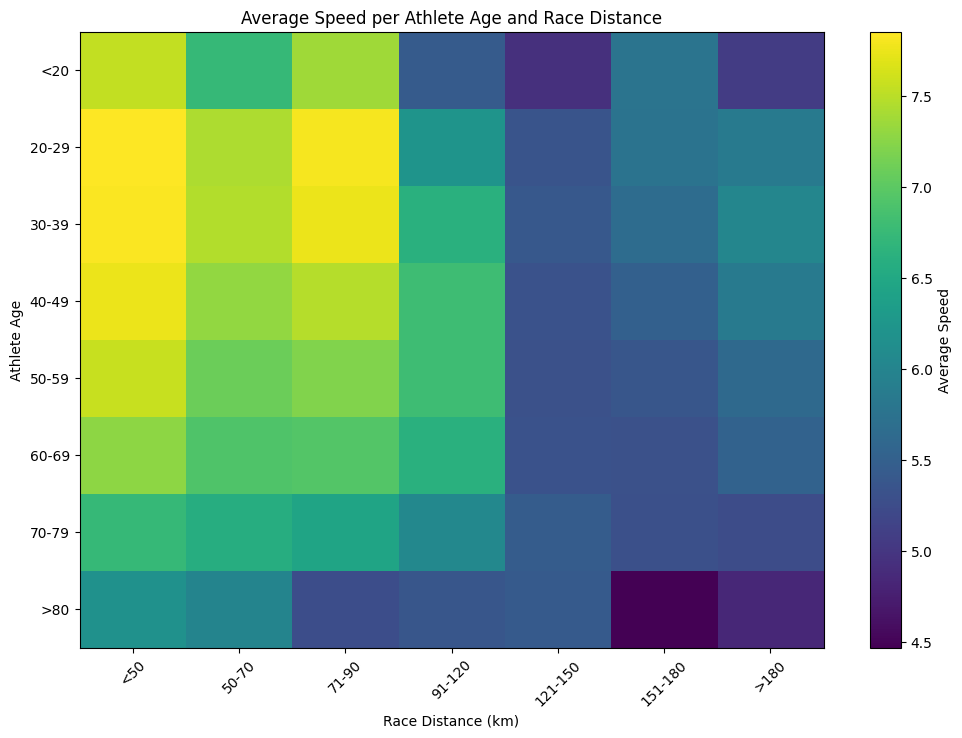

In [425]:
#10
#Speed by ages by distance
ages_speed = df
ages_speed['Athlete average speed'] = pd.to_numeric(ages_speed['Athlete average speed'], errors='coerce')
ages_speed = ages_speed.dropna(subset=['Athlete average speed'])
ages_speed = ages_speed.dropna(subset=['age_cat'])
ages_speed = ages_speed[ages_speed['Athlete average speed'] <= 20]

average_speeds = ages_speed.groupby(['age_cat', 'distance_range'])['Athlete average speed'].mean().unstack()

plt.figure(figsize=(12, 8))
plt.imshow(average_speeds, cmap='viridis', aspect='auto')
plt.colorbar(label='Average Speed')
plt.xticks(ticks=range(len(labels)), labels=labels, rotation=45)
plt.yticks(ticks=range(len(labels2)), labels=labels2)
plt.xlabel('Race Distance (km)')
plt.ylabel('Athlete Age')
plt.title('Average Speed per Athlete Age and Race Distance')
plt.show()

In [439]:


df.to_csv("ultra_data.csv", index=False)